# Zeldovich Approximation 2D

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
def whitenoise(N):    
    return np.random.normal(0,1,size=(N,N))

def removeNaN(ar):
    """Remove infinities and NaNs from an array"""
    ar[ar!=ar]=0
    ar[ar==np.inf]=0

In [3]:
def apply_powerlaw_power_spectrum(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fft2(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    removeNaN(freqs_2)
    f_fourier*=freqs_2
    return np.fft.ifft2(f_fourier).real

In [4]:
def get_potential_gradients(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fft2(den_real)
    freqs = np.fft.fftfreq(den.shape[0])
    del_sq_operator = -(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:]

    phi = den/del_sq_operator
    removeNaN(phi)

    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi

    grad_phi_x_real = np.fft.ifft2(grad_phi_x).real
    grad_phi_y_real = np.fft.ifft2(grad_phi_y).real

    return grad_phi_x_real, grad_phi_y_real

In [5]:
def evolved_particle_positions(den, time=0.025):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = len(den)
    x,y = np.mgrid[0.:N,0.:N]
    grad_x, grad_y = get_potential_gradients(den)
    x+=time*grad_x
    y+=time*grad_y
    x[x>N]-=N
    y[y>N]-=N
    x[x<0]+=N
    y[y<0]+=N
    return x.flatten(),y.flatten()

In [6]:
def densityCIC(x,y):   #  0 <  x, y, z < nGr in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    Np = np.size(x)
    macro = np.zeros([nGrid, nGrid])
    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 
        dx = dy = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy   
        
        wx1 = a1/dx
        wx2 = (dx - a1)/dx
        wy1 = b1/dy
        wy2 = (dy - b1)/dy        
        
        macro[i, j] += (wx1 * wy1)
        macro[np.mod(i+1,nGrid), j] += (wx2 * wy1)
        macro[i, np.mod(j+1,nGrid)] += (wx1 * wy2)
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid)] += (wx2 * wy2 )
    return macro

/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


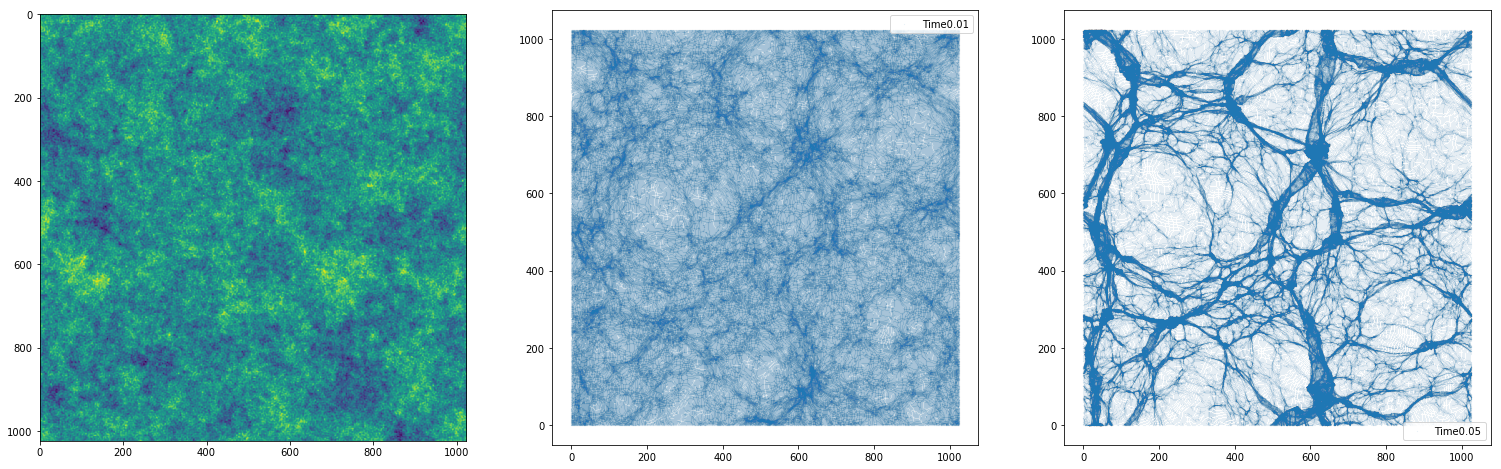

In [7]:
np.random.seed(11)

resolution = 1024
linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))

t0 = 0.01
t1 = 0.05
x0, y0 = evolved_particle_positions(linear_field, time=t0)
x1, y1 = evolved_particle_positions(linear_field, time=t1)

f, ax = plt.subplots(1, 3, figsize=(26,8))
ax[0].imshow(linear_field, label = 'Initial field')

ax[1].scatter(x0, y0, s=0.001, label = 'Time' + str(t0))
ax[2].scatter(x1, y1, s=0.001, label = 'Time' + str(t1))

ax[1].legend()
ax[2].legend()

plt.show()

## Cloud-in-cell density calculation in 2D

In [8]:
L = 1024.
nGrid = 1024

x0_1d = x1*nGrid/L 
x1_1d = y1*nGrid/L 

macro = densityCIC(x0_1d, x1_1d)

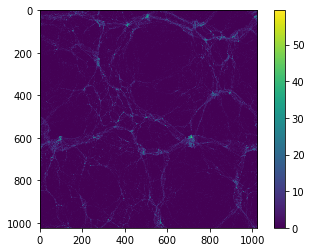

In [9]:
macro_max = macro.max()
macro_mean = macro.mean()
den = macro/macro_mean

plt.figure(3222)
plt.imshow(den)
plt.colorbar()
plt.show()

## Exercises

* Make a redshift evolution plot of ZA. Create a training and validation set (say 1000 images) with input and output images
* What about velocity? Include evolution of velocity in ZA framework (and plot the velocity field)
* Think of ways to speed-up the calculation at each step. For example, current CIC density estimates is awfully slow. 
* Write an equivalent in 3D ZA approximation. 
